# Installation

Install all the dependencies to make the most out of TorchCAM

In [1]:
!pip install torchvision matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Latest stable release

In [2]:
!pip install torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchcam-0.3.2-py3-none-any.whl (28 kB)


## From source

In [3]:
# Install the most up-to-date version from GitHub
!pip install -e git+https://github.com/frgfm/torch-cam.git#egg=torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining torchcam from git+https://github.com/frgfm/torch-cam.git#egg=torchcam
  Cloning https://github.com/frgfm/torch-cam.git to ./src/torchcam
  Running command git clone -q https://github.com/frgfm/torch-cam.git /content/src/torchcam
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: torchcam
    Found existing installation: torchcam 0.3.2
    Uninstalling torchcam-0.3.2:
      Successfully uninstalled torchcam-0.3.2
  Running setup.py develop for torchcam


Now go to `Runtime/Restart runtime` for your changes to take effect!

# Basic usage

In [1]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [2]:
# Download an image
!wget https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
# Set this to your image path if you wish to run it on your own data
img_path = "border-collie.jpg"

--2022-09-16 06:30:56--  https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
Resolving www.woopets.fr (www.woopets.fr)... 172.67.73.8, 104.26.13.50, 104.26.12.50, ...
Connecting to www.woopets.fr (www.woopets.fr)|172.67.73.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312888 (306K) [image/jpeg]
Saving to: ‘border-collie.jpg’

border-collie.jpg   100%[===================>] 305.55K  1.02MB/s    in 0.3s    

2022-09-16 06:30:57 (1.02 MB/s) - ‘border-collie.jpg’ saved [312888/312888]



In [3]:
# Instantiate your model here
model = resnet18(pretrained=True).eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Illustrate your classifier capabilities

In [4]:
cam_extractor = SmoothGradCAMpp(model)
# Get your input
img = read_image(img_path)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [5]:
# Notice that there is one CAM per target layer (here only 1)
for cam in cams:
  print(cam.shape)

torch.Size([1, 7, 7])


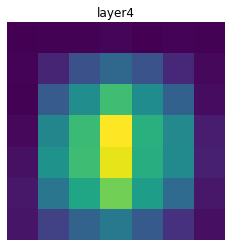

In [6]:
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(cam.squeeze(0).numpy()); plt.axis('off'); plt.title(name); plt.show()

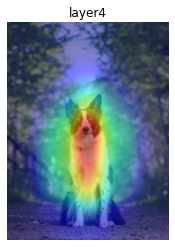

In [7]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [8]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

# Advanced tricks

## Extract localization cues

In [9]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
print(softmax(out, dim=1).max())

tensor(0.9115, grad_fn=<MaxBackward1>)


In [10]:
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

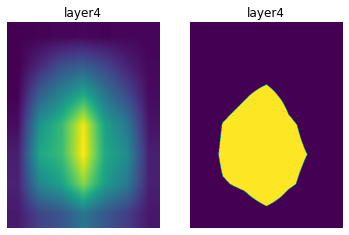

In [11]:
# Resize it
resized_cams = [resize(to_pil_image(cam.squeeze(0)), img.shape[-2:]) for cam in cams]
segmaps = [to_pil_image((resize(cam, img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]
# Plot it
for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
  _, axes = plt.subplots(1, 2)
  axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(name)
  axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(name)
  plt.show()

In [12]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

## Fuse CAMs from multiple layers

In [13]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model, ["layer2", "layer3", "layer4"])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [14]:
# This time, there are several CAMs
for cam in cams:
  print(cam.shape)

torch.Size([1, 28, 28])
torch.Size([1, 14, 14])
torch.Size([1, 7, 7])


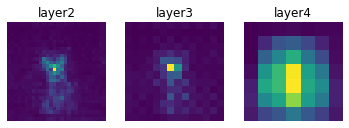

In [15]:
# The raw CAM
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.squeeze(0).numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

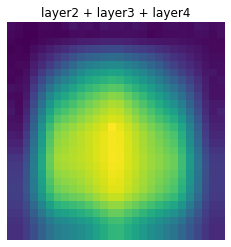

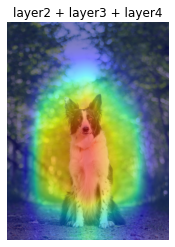

In [16]:
# Let's fuse them
fused_cam = cam_extractor.fuse_cams(cams)
# Plot the raw version
plt.imshow(fused_cam.squeeze(0).numpy()); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()
# Plot the overlayed version
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

In [17]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()